# Modelo clasificador de Tensorflow SpeechCommands

En lugar de utilizar librosa, utilizo la librería spectrogram.py <strong>"desarrollada"</strong>

In [1]:
print('Modelo clasificador de Tensorflow SpeechCommands.')

Modelo clasificador de Tensorflow SpeechCommands.


In [2]:
import numpy as np
from scipy.io import wavfile
import os
import pathlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt

In [3]:
# Cargado del dataset
import math
def create_dataset():
    y = []
    x = []
    #PATH = 'data/'
    #PATH = 'free_spoken_digit_dataset/recordings/'
    #PATH = 'Familia_SMNIST'
    #fs, _  = wavfile.read(os.path.join(PATH,os.listdir(PATH)[0]))
    fs = 5000


    data_dir = pathlib.Path('data/mini_speech_commands')
    if not data_dir.exists():
      tf.keras.utils.get_file(
          'mini_speech_commands.zip',
          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
          extract=True,
          cache_dir='.', cache_subdir='data')

    commands = np.array(tf.io.gfile.listdir(str(data_dir)))
    commands = commands[commands != 'README.md']
    commands = np.delete(commands, np.where(commands=='yes')[0])
    commands = np.delete(commands, np.where(commands=='no')[0])
    commands = np.delete(commands, np.where(commands=='up')[0])

    print('Commands:', commands)

    for com in commands:
      for file_name in os.listdir(os.path.join(data_dir,com)):
        file_path = os.path.join(data_dir,com+'/'+file_name)
        data, _ = librosa.load(file_path, sr=fs)
        data = np.array(data)
        data = np.append(data,[0]*(fs-len(data)))
        
        y.append(np.where(commands==com)[0][0])
        x.append(data)
    
    y = np.array(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
    
    return (x_train,y_train), (x_test,y_test), fs, commands


(x_train,y_train), (x_test,y_test), fs, commands= create_dataset()

182082353/182082353 [==============================] - 4s 0us/step
Commands: ['stop' 'down' 'right' 'left' 'go']


In [5]:
# Preprocesamiento de los datos
from spectrogram import create_spectrogram

n_mels = 32
n_fft = 256
noverlap = 0#n_fft//2
segundos = 1
largo = segundos*fs
bloques = largo // n_fft
print("bloques: ", bloques)
#bloques = largo//noverlap-1

def preprocess_data(x_train,x_test):
    mfcc_x_train = np.zeros((len(x_train),bloques,n_mels,1), dtype=np.float32)
    mfcc_x_test = np.zeros((len(x_test),bloques,n_mels,1), dtype=np.float32)

    print('Preparando train')
    for i_train in range(len(x_train)):
        dato = np.float32(x_train[i_train])
        starts,mfcc = create_spectrogram(dato,n_fft,n_mels,noverlap)
        #mfcc = librosa.power_to_db(mfcc)
        mfcc = np.reshape(mfcc, mfcc.shape + (1,))
        mfcc_x_train[i_train] = mfcc
                           
    print('Preparando test')
    for i_test in range(len(x_test)):
        dato = np.float32(x_test[i_test])
        starts,mfcc = create_spectrogram(dato,n_fft,n_mels,noverlap)
        #mfcc = librosa.power_to_db(mfcc)
        mfcc = np.reshape(mfcc, mfcc.shape + (1,))
        mfcc_x_test[i_test] = mfcc
    
    return mfcc_x_train , mfcc_x_test

mfcc_x_train,mfcc_x_test = preprocess_data(x_train,x_test)
print('mfcc_x_train.shape:', mfcc_x_train.shape)
print('mfcc_x_test.shape: ', mfcc_x_test.shape)

bloques:  19
Preparando train
Preparando test
mfcc_x_train.shape: (4000, 19, 32, 1)
mfcc_x_test.shape:  (1000, 19, 32, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

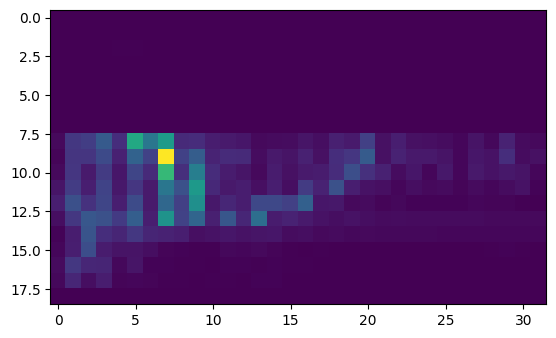

In [6]:
plt.imshow(mfcc_x_train[165,:,:,0])
plt.show

In [7]:
# Creación del modelo pequeño full convolucional
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(4,kernel_size=(3, 3),activation='relu',input_shape=mfcc_x_train[0].shape),
    tf.keras.layers.Conv2D(8,kernel_size=(3, 3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16,kernel_size=(2, 2),activation='relu'),
    tf.keras.layers.Conv2D(32,kernel_size=(2, 2),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32,kernel_size=(2, 2),activation='relu'),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(commands.shape[0],activation='softmax')    
])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 17, 30, 4)         40        
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 28, 8)         296       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 14, 8)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 13, 16)         528       
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 12, 32)         2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 6, 32)         0         
 2D)                                                    

In [ ]:
# Creación del modelo grande
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(4,kernel_size=(3, 3),activation='relu',input_shape=mfcc_x_train[0].shape),
    tf.keras.layers.Conv2D(8,kernel_size=(3, 3),activation='relu'),
    tf.keras.layers.Conv2D(16,kernel_size=(3, 3),activation='relu'),
    tf.keras.layers.Conv2D(32,kernel_size=(3, 3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(32,kernel_size=(3, 3),activation='relu'),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(commands.shape[0],activation='softmax')    
])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 17, 30, 4)         40        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 28, 8)         296       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 26, 16)        1168      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 8, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 6, 32)          9248      
_________________________________________________________________
flatten_2 (Flatten)          (None, 192)              

In [ ]:
# Creación del modelo mediano
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,kernel_size=(3, 3),activation='relu',input_shape=mfcc_x_train[0].shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32,kernel_size=(3, 3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(commands.shape[0],activation='softmax')    
])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 17, 30, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 15, 16)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 6, 13, 32)         4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 6, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2885      
Total params: 7,685
Trainable params: 7,685
Non-trainable params: 0
____________________________________________________

In [8]:
# Entrenamiento del modelo
history = model.fit(mfcc_x_train,y_train,epochs=100,batch_size=64,validation_data=(mfcc_x_test,y_test),verbose=2)

Epoch 1/100
63/63 - 12s - loss: 1.5543 - acc: 0.3243 - val_loss: 1.4608 - val_acc: 0.4330 - 12s/epoch - 198ms/step
Epoch 2/100
63/63 - 0s - loss: 1.3749 - acc: 0.4770 - val_loss: 1.2674 - val_acc: 0.5250 - 314ms/epoch - 5ms/step
Epoch 3/100
63/63 - 0s - loss: 1.2014 - acc: 0.5865 - val_loss: 1.0852 - val_acc: 0.6130 - 296ms/epoch - 5ms/step
Epoch 4/100
63/63 - 0s - loss: 1.0192 - acc: 0.6628 - val_loss: 0.9633 - val_acc: 0.6700 - 290ms/epoch - 5ms/step
Epoch 5/100
63/63 - 0s - loss: 0.9290 - acc: 0.6917 - val_loss: 0.9107 - val_acc: 0.6750 - 331ms/epoch - 5ms/step
Epoch 6/100
63/63 - 0s - loss: 0.8377 - acc: 0.7190 - val_loss: 0.8196 - val_acc: 0.7310 - 340ms/epoch - 5ms/step
Epoch 7/100
63/63 - 0s - loss: 0.7659 - acc: 0.7470 - val_loss: 0.7606 - val_acc: 0.7430 - 336ms/epoch - 5ms/step
Epoch 8/100
63/63 - 0s - loss: 0.6983 - acc: 0.7650 - val_loss: 0.7006 - val_acc: 0.7680 - 345ms/epoch - 5ms/step
Epoch 9/100
63/63 - 0s - loss: 0.6466 - acc: 0.7878 - val_loss: 0.6999 - val_acc: 0.762

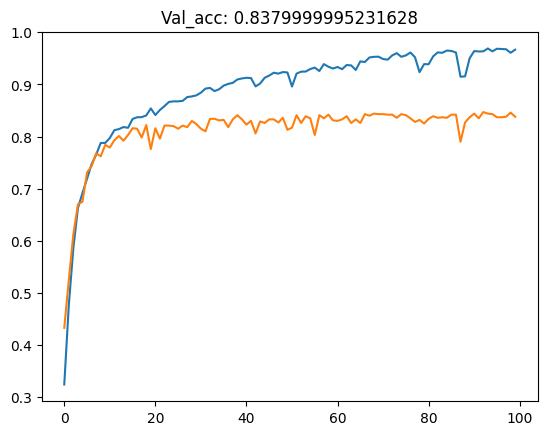

In [9]:
# Curvas accuracy
plt.title("Val_acc: "+str(history.history["val_acc"][-1]))
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])

In [10]:
# Exportar parámetros de espectrograma a C
inicio = ''
fmin = fmax = 0
step = n_fft - noverlap
len_nfft_nmels = (n_fft//2)//n_mels
print(f'''// Constantes autogeneradas: 

#ifndef {inicio}N_FFT
#define {inicio}N_MELS {n_mels}
#define {inicio}N_FFT {n_fft}
#define {inicio}N_FMIN {fmin}
#define {inicio}N_FMAX {fmax}
#define {inicio}FRAME_LENGTH {largo}
#define {inicio}SAMPLE_RATE {fs}
#define {inicio}BLOCKS {bloques}
#define {inicio}N_FFT_TABLE {int(n_fft/2)}
#define {inicio}NOVERLAP {noverlap}
#define {inicio}STEP {step}
#define {inicio}LEN_NFFT_NMELS {len_nfft_nmels}
#define {inicio}SPEC_SIZE {mfcc_x_test[0].flatten().shape[0]}
#define {inicio}DELAY_US {int(1/fs*1000*1000)}
#endif
''')


// Constantes autogeneradas: 

#ifndef N_FFT
#define N_MELS 32
#define N_FFT 256
#define N_FMIN 0
#define N_FMAX 0
#define FRAME_LENGTH 5000
#define SAMPLE_RATE 5000
#define BLOCKS 19
#define N_FFT_TABLE 128
#define NOVERLAP 0
#define STEP 256
#define LEN_NFFT_NMELS 4
#define SPEC_SIZE 608
#define DELAY_US 200
#endif



In [11]:
np.save("x_train.npy", x_train)
np.save("y_train.npy", y_train)
np.save("x_test.npy", x_test)
np.save("y_test.npy", y_test)
np.save("mfcc_x_train.npy", mfcc_x_train)
np.save("mfcc_x_test.npy", mfcc_x_test)
model.save("model.h5")

# Recuperar modelo y datos

## Recuperar modelo, datos de prueba y entrenamiento

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('model.h5')
model.summary()
x_train = np.load('x_train.npy', allow_pickle=True)
mfcc_x_train = np.load('mfcc_x_train.npy', allow_pickle=True)
y_train = np.load('y_train.npy', allow_pickle=True)

x_test = np.load('x_test.npy', allow_pickle=True)
mfcc_x_test = np.load('mfcc_x_test.npy', allow_pickle=True)
y_test = np.load('y_test.npy', allow_pickle=True)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 15, 14, 8)         80        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 5, 4, 8)           0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 4, 3, 16)          528       
_________________________________________________________________
flatten_15 (Flatten)         (None, 192)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 16)                3088      
_________________________________________________________________
dense_41 (Dense)             (None, 10)                170       
Total params: 3,866
Trainable params: 3,866
Non-trainable params: 0
___________________________________________________

In [ ]:
model.evaluate(mfcc_x_test, y_test)

19/19 [==============================] - 0s 3ms/step - loss: 0.6135 - acc: 0.8350


[0.6134818196296692, 0.8349999785423279]

## Recuperar un dato del test

In [12]:
import matplotlib.pyplot as plt
import numpy as np

dim_f = bloques
dim_c = n_mels

# Exportación a C
def imprimir_entrada(entrada):
    s=''
    for i in entrada:
        #i_string = f"{i}, "
        i_string = "%.7f, " % (i)
        s+=i_string
    print(f'float input_data[] = {{\n\t{s[:-2]}\n}};')

# Función que usamos siempre modificada
def visualizar_muestra(numero, repeticion, x_test, the_real_x_train, y_test, model, _imprimir_prediccion = 1, _imprimir_matriz = 0, _imprimir_vector = 0, _grafico_color = 0):
    '''
     Visualizar una muestra (imagen) e informacion adicional segun parametros
     Recibe: 
            numero: Número a buscar
            repeticion: Repetición dentro de x_test
            x_test, y_test: vectores de dataset de prueba
            model: necesario solo si _imprimir_prediccion = 1
    '''

    # Busqueda del número
    n_muestra = np.where(y_test==numero)[0][repeticion]
    muestra = x_test[n_muestra][:,:,:]

  # Visualización de datos
    if _imprimir_matriz:
        print('Matriz\n', muestra.reshape(dim_f,dim_c),'\n')

    if _imprimir_vector:
        #print('Arreglo\n', muestra.reshape(1,dim_f*dim_c),'\n')
        print("Arreglo\n")
        imprimir_entrada(the_real_x_train[n_muestra].flatten())

    muestra = np.reshape(muestra, (1,dim_f,dim_c,1))
    
    if _grafico_color:
        plt.imshow(muestra[0,:,:,0])
    else:
        plt.imshow(muestra[0,:,:,0], cmap='gray')

    if _imprimir_prediccion:
        plt.title(f"Número: {commands[y_test[n_muestra]]} - Predicción: {np.argmax(model.predict(np.reshape(x_test[n_muestra], ((1, )+ x_test[n_muestra].shape))))}")
    else:
        plt.title(f"Número: {commands[y_test[n_muestra]]}")
    
    plt.show()

In [13]:
# Elección del número
numero = 5
repeticion = 1

# Qué datos adicionales imprimir
_imprimir_prediccion = 0
_imprimir_matriz = 0
_imprimir_vector = 0
_grafico_color = 1
visualizar_muestra(numero, repeticion, mfcc_x_test, x_test, y_test, model, _imprimir_prediccion, _imprimir_matriz, _imprimir_vector, _grafico_color)

IndexError: ignored

# Datos a C para espectrogramizarlos

In [14]:
# Busqueda del número
numero = 9
repeticion = 5

# Graficar numero
n_muestra = np.where(y_test==numero)[0][repeticion]
muestra = x_test[n_muestra]
grafico_librosa = mfcc_x_test[n_muestra][:,:,:]
grafico_librosa = np.reshape(grafico_librosa, (1,dim_f,dim_c,1))
plt.imshow(grafico_librosa[0,:,:,0])
plt.title(f"Espectrograma Librosa - shape = {muestra.shape} - {grafico_librosa.shape}")
plt.show()

IndexError: ignored

In [15]:
def dato_to_c(entrada):
    s=''
    for i in entrada:
        #i_string = f"{i}, "
        i_string = "%.7f, " % (i)
        s+=i_string
    #s+=f"{{s}}, \n\n"
    return s[:-2]

def save_to_file(filename, content):
    file = open(filename, 'w') #guardar
    file.write(content)
    file.close()    

filename = 'audio'
datos_en_c=f'float input_data[] = {{\n\t{dato_to_c(muestra)}\n}};'
save_to_file(filename+'.h', datos_en_c)

NameError: ignored

## Pruba modelo con espectrograma obtenido en C

In [ ]:
# Espectrograma de tamaño: 224 

espectrograma_vec = np.array([
	0.009991, 0.002521, 0.000969, 0.001279, 0.000481, 0.000193, 0.000508, 0.000363, 0.000330, 0.000253, 0.000245, 0.000178, 0.000168, 0.000164, 0.000135, 0.000057, 0.008663, 0.003412, 0.002636, 0.001392, 0.000666, 0.000586, 0.000494, 0.000926, 0.001066, 0.000580, 0.000889, 0.000964, 0.000581, 0.000494, 0.000557, 0.000312, 0.014475, 0.006270, 0.001640, 0.001956, 0.000898, 0.000615, 0.000475, 0.000767, 0.000846, 0.001018, 0.000678, 0.000566, 0.000366, 0.000601, 0.000790, 0.000088, 0.016443, 0.045199, 0.081060, 0.051751, 0.051471, 0.069196, 0.045504, 0.104628, 0.102096, 0.056377, 0.034297, 0.014271, 0.009502, 0.011378, 0.003119, 0.002554, 0.025151, 0.011874, 0.104472, 0.012228, 0.085046, 0.019489, 0.077519, 0.060456, 0.136929, 0.091186, 0.174360, 0.018088, 0.039053, 0.013199, 0.030906, 0.003576, 0.021860, 0.029716, 0.091443, 0.017132, 0.055866, 0.025474, 0.050156, 0.049902, 0.071020, 0.030833, 0.034671, 0.013358, 0.012414, 0.007665, 0.007425, 0.001234, 0.026866, 0.027974, 0.122189, 0.017723, 0.070768, 0.032162, 0.042481, 0.052062, 0.023627, 0.067802, 0.007350, 0.015900, 0.008055, 0.008601, 0.006586, 0.003624, 0.026311, 0.009140, 0.114769, 0.049009, 0.016082, 0.050650, 0.010767, 0.018593, 0.018557, 0.004106, 0.005373, 0.002648, 0.002048, 0.001667, 0.001323, 0.000489, 0.027729, 0.011368, 0.025950, 0.048185, 0.010079, 0.006203, 0.007935, 0.004121, 0.003194, 0.002354, 0.002554, 0.001929, 0.002115, 0.001818, 0.001787, 0.001529, 0.025214, 0.004208, 0.002132, 0.005017, 0.001265, 0.000816, 0.000903, 0.001313, 0.001539, 0.001021, 0.000765, 0.000774, 0.000480, 0.000651, 0.000645, 0.000301, 0.000656, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000656, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000656, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000656, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 
])
espectrograma_vec = np.reshape(espectrograma_vec, (bloques, n_mels))

_convert_to_db = 0

ValueError: cannot reshape array of size 224 into shape (34,16)

In [ ]:
#if _convert_to_db==0:
#    espectrograma_vec = librosa.power_to_db(espectrograma_vec, ref=np.max)
#grafico_espectrograma = espectrograma_vec.reshape(bloques,n_mels).T

plt.title(f"espectrograma_vec.shape: {espectrograma_vec.shape} - Predicción: {np.argmax(model.predict(np.reshape(espectrograma_vec, (1,bloques,n_mels,1))))}")
plt.imshow(espectrograma_vec)

ValueError: cannot reshape array of size 224 into shape (1,34,16,1)

## Con datos grabados

In [ ]:
# Cargar dato
fs,test = wavfile.read('nine.wav')
test = test[:,1]
mfcc_test = librosa.power_to_db(librosa.feature.melspectrogram(np.float32(test), sr=fs, n_fft=1024, hop_length=512, n_mels=64), ref=np.max)
mfcc_test = np.reshape(mfcc_test,mfcc_test.shape + (1,))
mfcc_test = tf.image.resize(mfcc_test, (dim_f,dim_c)).eval(session=tf.compat.v1.Session())
mfcc_test = np.reshape(mfcc_test, (1,) + mfcc_test.shape)

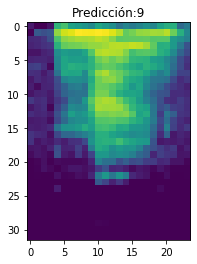

In [ ]:
# Ejecutar inferencia y mostrar resultado
plt.imshow(mfcc_test[0,:,:,0])
plt.title("Predicción:" + str(model.predict_classes(mfcc_test)[0]))
plt.show()
sd.play(test, fs)

## Con datos grabados

In [ ]:
# Cargar dato
fs,test = wavfile.read('nine.wav')
test = test[:,1]
mfcc_test = librosa.power_to_db(librosa.feature.melspectrogram(np.float32(test), sr=fs, n_fft=1024, hop_length=512, n_mels=128), ref=np.max)
mfcc_test = np.reshape(mfcc_test,mfcc_test.shape + (1,))
mfcc_test = tf.image.resize(mfcc_test, (360*4,720*4))#.eval(session=tf.compat.v1.Session())
mfcc_test = np.reshape(mfcc_test, (1,) + mfcc_test.shape)

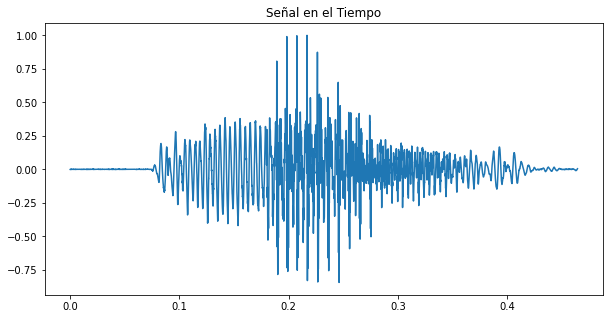

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Señal en el Tiempo")
t = [n/fs for n in range(0,test.shape[0])]
plt.plot(t, test/test.max())
plt.savefig("tiempo.png")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


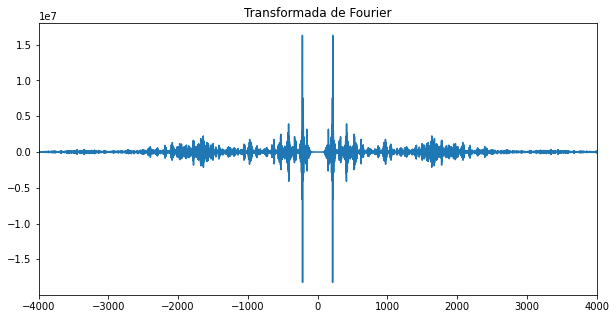

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Transformada de Fourier")
plt.plot(np.fft.fftshift(np.fft.fftfreq(test.shape[0], 1/fs)),np.fft.fftshift(np.fft.fft(test)))
plt.xlim([-4000, 4000])
plt.savefig("frec.png")

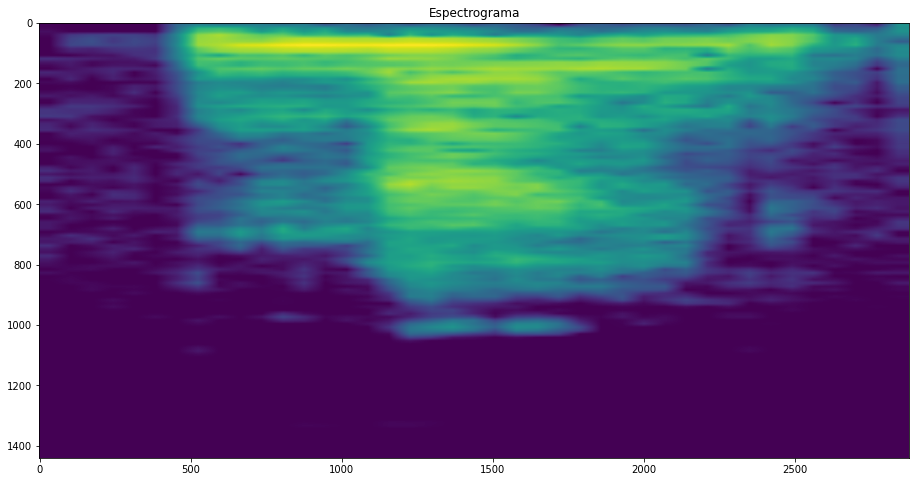

In [ ]:
# Ejecutar inferencia y mostrar resultado
plt.figure(figsize=(2*8,4*2))
plt.imshow(mfcc_test[0,:,:,0])
#plt.title("Predicción:" + str(model.predict_classes(mfcc_test)[0]))
plt.title("Espectrograma")
plt.savefig("espectrograma.png")
#sd.play(test, fs)

In [ ]:
mfcc_test.shape

(1, 1440, 2880, 1)

# Prueba audios fede

In [ ]:
from free_spoken_digit_dataset.utils.trimmer import trim_silence

In [ ]:
largo = 2189

In [ ]:
# Cargado del dataset
def create_datatest():
    y = []
    x = []
    #PATH = 'Fede_SNIST/'
    PATH = 'Marcos_SMNIST/'
    #PATH = 'Norma_SMNIST_completo/'
    #PATH = 'Martin_SMNIST/'
    
    #fs, _  = wavfile.read(os.path.join(PATH,os.listdir(PATH)[0]))
    fs = 5000

    print('Cargando el datatest...')
    for file_name in os.listdir(PATH)[:]:
        #_, data = wavfile.read(os.path.join(PATH,file_name))
        data, _ = librosa.load(os.path.join(PATH,file_name), sr=fs)
        #new_data = trim_silence(data,0.008) # Fede
        #new_data = trim_silence(data,0.025) # Marcos
        #new_data = trim_silence(data,0.018) # Norma
        new_data = trim_silence(data,0.014) # Martin
        #new_data = data
        y.append(int(file_name[0]))
        x.append(new_data)
    
    x_len_norm = []
    for x_indice, x_element in enumerate(x):
        len_element = len(x_element) 
        if(len_element > largo):
            x_len_norm.append(x_element[:largo])
        if(len_element < largo):
            x_len_norm.append(np.append(x_element, [0]*(largo-len_element)))

    y = np.array(y)
    x = np.array(x_len_norm)
    
    #print('Dividiendo en train y test...')
    #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
    
    print('Listo.')
    return x,y

x,y = create_datatest()

Cargando el datatest...
Listo.


In [ ]:
# Preprocesamiento de los datos
from spectrogram import create_spectrogram

n_mels = 16
n_fft = 128
noverlap = 0#n_fft//2
bloques = largo // n_fft
print("bloques: ", bloques)
#bloques = largo//noverlap-1

def preprocess_datatest(x_test):
    mfcc_x_test = np.zeros((len(x_test),bloques,n_mels,1), dtype=np.float32)
                           
    print('Preparando test')
    for i_test in range(len(x_test)):
        dato = np.float32(x_test[i_test])
        starts,mfcc = create_spectrogram(dato,n_fft,n_mels,noverlap)
        #mfcc = librosa.power_to_db(mfcc)
        mfcc = np.reshape(mfcc, mfcc.shape + (1,))
        mfcc_x_test[i_test] = mfcc
    
    return mfcc_x_test

mfcc_x = preprocess_datatest(x)
print('mfcc_x.shape:', mfcc_x.shape)

bloques:  17
Preparando test
mfcc_x.shape: (20, 17, 16, 1)


In [ ]:
model.evaluate(mfcc_x, y)

1/1 [==============================] - 0s 18ms/step - loss: 1.2372 - acc: 0.7000


[1.23722243309021, 0.699999988079071]

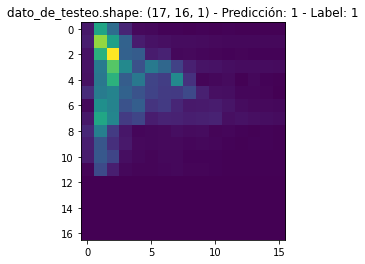

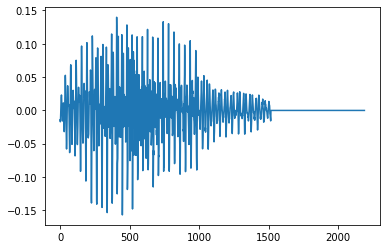

In [ ]:
num = 3
dato_de_testeo = mfcc_x[num]
plt.title(f"dato_de_testeo.shape: {dato_de_testeo.shape} - Predicción: {np.argmax(model.predict(np.reshape(dato_de_testeo, (1,bloques,n_mels,1))))} - Label: {y[num]}")
plt.imshow(dato_de_testeo.reshape((bloques,n_mels)))
plt.show()
plt.plot(x[num])
plt.show()


Todo terminó

In [ ]:
import numpy as np

np.save("fede_smnist_x_test.npy", x)
np.save("fede_smnist_y_test.npy", y)